In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import sys
sys.path.insert(0, '..')
from isegm.ritm.utils import exp

device = torch.device('cuda:0')
cfg = exp.load_config_file('config.yml', return_edict=True)

# Config

In [2]:
train_config_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/configs/train_config.yaml'
from hydra import compose, initialize
from omegaconf import OmegaConf

overrides = [
    "exp_name='Static disks BceDiceLoss'",
    "model_type='FocalClick'",
    "clicker.mode='locked'",
    "iterative_trainer=False",
    "dist_map_mode='disk'",
    "dataset.train='LIDC_2D'",
    "dataset.val='LIDC_2D_VAL'",
    "preprocessing/windowing=lidc",
    "preprocessing.num_input_channels=3",
    "augmentation_type='target_crop'",
    "target_crop_augmentation.crop_probability=1",
    "total_epochs=300",
    "batch_size=40",
    "iterative_evaluation_interval=10",
    "early_stopping_patience=75",
    "lr_scheduling.patience=25",
    "hydra.job.chdir=False",

]

with initialize(version_base=None, config_path="./configs", job_name="train_test"):
    train_cfg = compose(config_name="train_config", overrides=overrides)

print(OmegaConf.to_yaml(train_cfg))

data_paths:
  INTERACTIVE_MODELS_PATH: ./weights
  EXPS_PATH: ./experiments
  GRABCUT_PATH: /home/admin/workspace/project/data/datasets/GrabCut
  BERKELEY_PATH: /home/admin/workspace/project/data/datasets/Berkeley
  DAVIS_PATH: /home/admin/workspace/project/data/datasets/DAVIS
  COCO_MVAL_PATH: /home/admin/workspace/project/data/datasets/COCO_MVal
  PASCALVOC_PATH: /home/admin/workspace/project/data/datasets/VOC2012/VOCdevkit/VOC2012
  DAVIS585_PATH: /home/admin/workspace/project/data/datasets/InterDavis/Selected_480P
  BRATS_VAL_PATH: /gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/BraTS_2d/val
  LIDC_VAL_PATH: /gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/val
  LIDC_TEST_PATH: /gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/test
  LIDC_FULL_VAL_PATH: /gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D-FULL/val
  LIDC_FULL_TEST_P

# Model

In [4]:
from easydict import EasyDict as edict

from isegm.utils import common_utils


def init_model(train_cfg, device):
    model_cfg = edict()
    model_cfg.crop_size = (train_cfg.input_size.height, train_cfg.input_size.width)
    model_cfg.num_max_points = train_cfg.max_clicks
    model_cfg.name = f'{train_cfg.model_type}'
        
    model = common_utils.load_model(train_cfg, model_cfg, device, train=True)

    return model, model_cfg


model, model_cfg = init_model(train_cfg, device)

Model args: {'pipeline_version': 's2', 'width': 32, 'ocr_width': 128, 'small': False, 'with_aux_output': True, 'use_leaky_relu': True, 'use_rgb_conv': False, 'dist_map_mode': 'disk', 'norm_radius': 5, 'with_prev_mask': True, 'overwrite_click_maps': False, 'model_type': 'FocalClick', 'training': True, 'overrides': {'use_rgb_conv': False, 'dist_map_mode': 'disk', 'overwrite_click_maps': False}}


Loading pretrained weights from: weights/author_pretrained_combined.pth
Loading pretrained weights from: weights/author_pretrained_combined.pth
Loading pretrained weights from: weights/author_pretrained_combined.pth
Loaded FocalClick model (class: HRNetModel), use_pretrained_weights: True
Loaded FocalClick model (class: HRNetModel), use_pretrained_weights: True
Loaded FocalClick model (class: HRNetModel), use_pretrained_weights: True


# Loss

In [5]:
loss_cfg = common_utils.get_loss_configuration(train_cfg)

Loss configuration for model: FocalClick: {'instance_loss': BceDiceLoss(), 'instance_loss_weight': 1.0, 'instance_aux_loss': SigmoidBinaryCrossEntropyLoss(), 'instance_aux_loss_weight': 0.4, 'instance_refine_loss': WFNL(), 'instance_refine_loss_weight': 1.0, 'trimap_loss': BCEWithLogitsLoss(), 'trimap_loss_weight': 1.0}
Loss configuration for model: FocalClick: {'instance_loss': BceDiceLoss(), 'instance_loss_weight': 1.0, 'instance_aux_loss': SigmoidBinaryCrossEntropyLoss(), 'instance_aux_loss_weight': 0.4, 'instance_refine_loss': WFNL(), 'instance_refine_loss_weight': 1.0, 'trimap_loss': BCEWithLogitsLoss(), 'trimap_loss_weight': 1.0}
Loss configuration for model: FocalClick: {'instance_loss': BceDiceLoss(), 'instance_loss_weight': 1.0, 'instance_aux_loss': SigmoidBinaryCrossEntropyLoss(), 'instance_aux_loss_weight': 0.4, 'instance_refine_loss': WFNL(), 'instance_refine_loss_weight': 1.0, 'trimap_loss': BCEWithLogitsLoss(), 'trimap_loss_weight': 1.0}


In [6]:
loss_cfg['instance_loss'], loss_cfg['instance_aux_loss']

(BceDiceLoss(), SigmoidBinaryCrossEntropyLoss())

# Datasets

In [7]:
train_set, val_set = common_utils.configure_datasets(train_cfg, model_cfg)

Preprocessing config: {'windowing': {'min': -900, 'max': 600, 'enabled': True}, 'enhancements': {'contrast': -1, 'brightness': -1, 'sharpness': -1, 'gaussian_blur': -1}, 'convert_to_rgb': False, 'normalize': True, 'num_input_channels': 3}
Preprocessing config: {'windowing': {'min': -900, 'max': 600, 'enabled': True}, 'enhancements': {'contrast': -1, 'brightness': -1, 'sharpness': -1, 'gaussian_blur': -1}, 'convert_to_rgb': False, 'normalize': True, 'num_input_channels': 3}
Preprocessing config: {'windowing': {'min': -900, 'max': 600, 'enabled': True}, 'enhancements': {'contrast': -1, 'brightness': -1, 'sharpness': -1, 'gaussian_blur': -1}, 'convert_to_rgb': False, 'normalize': True, 'num_input_channels': 3}
Refiner data for model FocalClick
Refiner data for model FocalClick
Refiner data for model FocalClick
Train set: len: 416, epoch_len: -1
Train set: len: 416, epoch_len: -1
Train set: len: 416, epoch_len: -1
Val set: len: 57, epoch_len: -1
Val set: len: 57, epoch_len: -1
Val set: len

In [22]:
import cv2
import numpy as np
from scipy.stats import truncnorm


def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

class ProbabilisticAlignedAlternativeAugmentator:
    def __init__(
        self,
        ratio,
        crop_probability,
        force_mask_in_crop=True,
        target_size=(256, 256),
        flip=True,
        distribution='Uniform',
        gs_center=1,
        gs_sd=0.4,
        color_augmentator=None,
        alternative_crop_augmentator=None,
    ):
        '''
        distribution belongs to [ 'Uniform, Gaussian' ]
        '''
        self.ratio = ratio
        self.target_size = target_size
        self.flip = flip
        self.distribution = distribution
        self.gaussian = get_truncated_normal(
            mean=gs_center, sd=gs_sd, low=ratio[0], upp=ratio[1]
        )
        self.color_augmentator = color_augmentator
        self.crop_probability = crop_probability
        self.force_mask_in_crop = force_mask_in_crop
        self.alternative_crop_augmentator = alternative_crop_augmentator

    def __call__(self, image, mask):
        do_target_crop = np.random.rand() <= self.crop_probability
        if do_target_crop:
            mask_x1, mask_y1, mask_x2, mask_y2 = self._get_box_corners(mask)

            if self.distribution == 'Uniform':
                hr, wr = np.random.uniform(*self.ratio), np.random.uniform(*self.ratio)
            elif self.distribution == 'Gaussian':
                hr, wr = self.gaussian.rvs(2)

            H, W = image.shape[0], image.shape[1]
            h, w = int(H * hr), int(W * wr)
            if hr > 1 or wr > 1:
                image, mask = self.pad_image_mask(image, mask, hr, wr)
                H, W = image.shape[0], image.shape[1]

            if self.force_mask_in_crop:
                min_crop_start_y = max(0, mask_y1 - int(h * 0.9))
                max_crop_start_y = min(H - h, mask_y2 - int(h * 0.1))
                y1 = np.random.randint(min_crop_start_y, max_crop_start_y)

                min_crop_start_x = max(0, mask_x1 - int(w * 0.9))
                max_crop_start_x = min(W - w, mask_x2 - int(w * 0.1))
                x1 = np.random.randint(min_crop_start_x, max_crop_start_x)

                y2 = y1 + h
                x2 = x1 + w

            else:
                y1 = np.random.randint(0, H - h)
                x1 = np.random.randint(0, W - w)
                y2 = y1 + h
                x2 = x1 + w
                
            image_crop = image[y1:y2, x1:x2, :]
            image_crop = cv2.resize(image_crop, self.target_size)
            mask_crop = mask[y1:y2, x1:x2, :].astype(np.uint8)
            mask_crop = (cv2.resize(mask_crop, self.target_size)).astype(np.int32)
        else:
            # no target crop
            x1, y1, x2, y2 = 0, 0, image.shape[1], image.shape[0]
            if self.alternative_crop_augmentator is not None:
                aug_output = self.alternative_crop_augmentator(image, mask)
                image_crop = aug_output['image']
                mask_crop = aug_output['mask']
            else:
                image_crop = cv2.resize(image, self.target_size)
                mask_crop = (cv2.resize(mask, self.target_size)).astype(np.int32)
            

        if len(mask_crop.shape) == 2:
            mask_crop = np.expand_dims(mask_crop, -1)

        if self.flip:
            if np.random.rand() < 0.3:
                image_crop = np.flip(image_crop, 0)
                mask_crop = np.flip(mask_crop, 0)
            if np.random.rand() < 0.3:
                image_crop = np.flip(image_crop, 1)
                mask_crop = np.flip(mask_crop, 1)

        image_crop = np.ascontiguousarray(image_crop)
        mask_crop = np.ascontiguousarray(mask_crop)

        if self.color_augmentator is not None:
            image_crop = self.color_augmentator(image=image_crop)['image']

        aug_output = {}
        aug_output['image'] = image_crop
        aug_output['mask'] = mask_crop
        return aug_output

    def _get_box_corners(self, mask):
        mask[mask > 0] = 1
        mask = mask.astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])

        return x, y, x + w, y + h

    def pad_image_mask(self, image, mask, hr, wr):
        H, W = image.shape[0], image.shape[1]
        if hr > 1:
            new_h = int(H * hr) + 1
            pad_h = new_h - H
            pad_h1 = np.random.randint(0, pad_h)
            pad_h2 = pad_h - pad_h1
            image = np.pad(image, ((pad_h1, pad_h2), (0, 0), (0, 0)), 'constant')
            mask = np.pad(mask, ((pad_h1, pad_h2), (0, 0), (0, 0)), 'constant')

        if wr > 1:
            new_w = int(W * wr) + 1
            pad_w = new_w - W
            pad_w1 = np.random.randint(0, pad_w)
            pad_w2 = pad_w - pad_w1
            image = np.pad(image, ((0, 0), (pad_w1, pad_w2), (0, 0)), 'constant')
            mask = np.pad(mask, ((0, 0), (pad_w1, pad_w2), (0, 0)), 'constant')
        return image, mask


In [55]:
target_crop_size = (
    train_cfg.target_crop_augmentation.crop_size,
    train_cfg.target_crop_augmentation.crop_size,
)
augmentator = ProbabilisticAlignedAlternativeAugmentator(
    ratio=[
        train_cfg.target_crop_augmentation.low,
        train_cfg.target_crop_augmentation.high,
    ],
    target_size=target_crop_size,
    # crop_probability=train_cfg.target_crop_augmentation.crop_probability,
    crop_probability=0,
    flip=True,
    distribution='Gaussian',
    gs_center=1,
)
augmentator

In [56]:
train_set.augmentator = augmentator

In [57]:
len(train_set), len(val_set)

(416, 57)

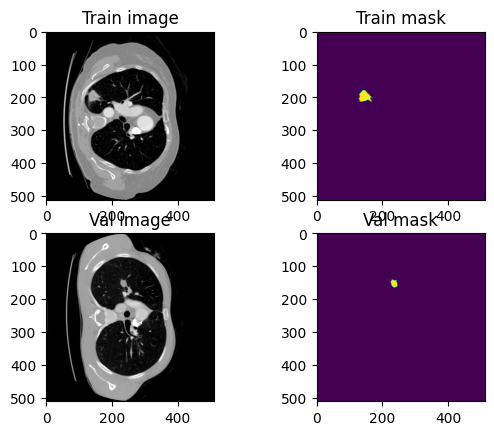

In [58]:
train_sample = train_set.get_sample(0)
val_sample = val_set.get_sample(0)

fig, ax = plt.subplots(2, 2)
ax[0, 0].set_title('Train image')
ax[0, 0].imshow(train_sample.image[:, :, 0], cmap='gray')
ax[0, 1].set_title('Train mask')
ax[0, 1].imshow(train_sample.gt_mask)

ax[1, 0].set_title('Val image')
ax[1, 0].imshow(val_sample.image[:, :, 0], cmap='gray')
ax[1, 1].set_title('Val mask')
ax[1, 1].imshow(val_sample.gt_mask)

# Trainer

In [59]:
trainer = common_utils.get_trainer(train_cfg, model_cfg, model, loss_cfg, train_set, val_set, device)


Dataset of 416 samples was loaded for training.
Dataset of 416 samples was loaded for training.
Dataset of 416 samples was loaded for training.
Dataset of 57 samples was loaded for validation.
Dataset of 57 samples was loaded for validation.
Dataset of 57 samples was loaded for validation.
/gpfs/space/home/donatasv/.conda/envs/bcv_clickseg/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Train data batch dimensions:
Train data batch dimensions:
Train data batch dimensions:


KeyboardInterrupt: 

In [ ]:
trainer

In [ ]:
trainer.train_metrics, trainer.val_metrics

([<isegm.model.metrics.AdaptiveIoU at 0x2ad323f3e650>,
  <isegm.model.metrics.IoU at 0x2ad323267ed0>])

In [ ]:
train_batch = next(iter(trainer.train_data))
train_batch.keys()

dict_keys(['images', 'points', 'instances', 'trimap', 'images_focus', 'instances_focus', 'trimap_focus', 'points_focus', 'rois'])

In [ ]:
print(train_batch['images'].shape, train_batch['points'].shape, train_batch['instances'].shape)

torch.Size([40, 3, 256, 256]) torch.Size([40, 48, 4]) torch.Size([40, 1, 256, 256])


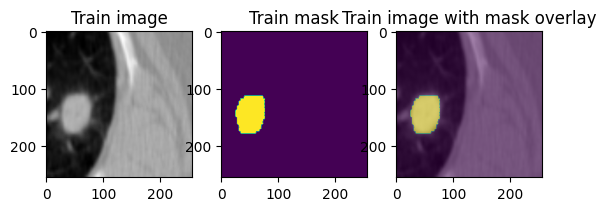

In [ ]:
idx = 8
train_image = train_batch['images'][idx][0]
train_gt_mask = train_batch['instances'][idx][0]
train_points = train_batch['points'][idx][0]

fig, ax = plt.subplots(1, 3)
ax[0].set_title('Train image')
ax[0].imshow(train_image, cmap='gray')
ax[1].set_title('Train mask')
ax[1].imshow(train_gt_mask)
ax[2].set_title('Train image with mask overlay')
ax[2].imshow(train_image, cmap='gray')
ax[2].imshow(train_gt_mask, alpha=0.5)

In [18]:
pos_points = train_points[:len(train_points) // 2]
pos_points = torch.stack([point for point in pos_points if point[0] > 0], dim=0)
neg_points = train_points[len(train_points) // 2:]
neg_points = torch.stack([point for point in neg_points if point[0] > 0], dim=0)
pos_points, neg_points


(tensor([[265., 346.,   0.,   5.],
         [264., 343., 100.,   5.],
         [266., 348., 100.,   5.],
         [268., 343., 100.,   5.],
         [267., 342., 100.,   5.]]),
 tensor([[256., 350., 100.,   5.],
         [406., 136., 100.,   5.],
         [262., 335., 100.,   5.]]))

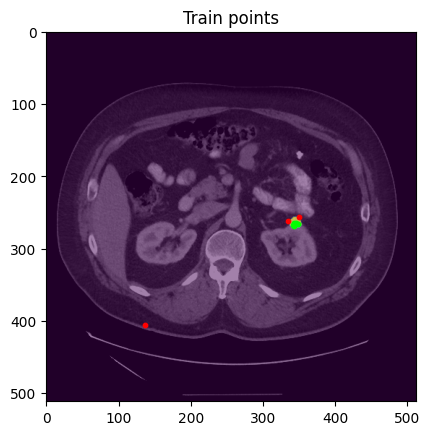

In [19]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Train points')
ax.imshow(train_image[0], cmap='gray')
ax.imshow(train_gt_mask[0], alpha=0.5)
ax.scatter(pos_points[:, 1], pos_points[:, 0], c='lime', s=10)
ax.scatter(neg_points[:, 1], neg_points[:, 0], c='red', s=10)

## Batch forward

In [20]:
# og_model = trainer.net
# from isegm.inference import utils
# checkpoint_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/2024-03-15/17-31-09-RITM-KITS23_2D_TUMOURS-Static disks small dataset/checkpoints/best_model.pth'
# trained_model = utils.load_is_model(checkpoint_path, device, model_type='RITM')
# for param in trained_model.parameters():
#     param.requires_grad = True

In [21]:
# trainer.net = og_model
# trainer.net = trained_model

In [22]:
batch_data = {k: v.to(trainer.device) for k, v in train_batch.items()}
gpu_images = batch_data['images'][:1]
gpu_points = batch_data['points'][:1]
gpu_gt_mask = batch_data['instances'][:1]
prev_output = torch.zeros_like(gpu_images, dtype=torch.float32)[:, :1, :, :]

## Pre backprop inference

2


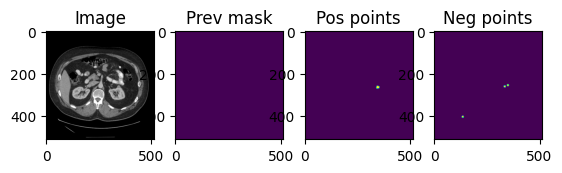

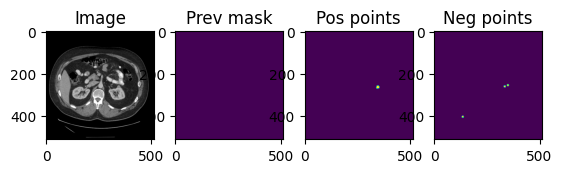

In [23]:
import random

validation = False

orig_image, orig_gt_mask, orig_points = (
                gpu_images.clone(),
                gpu_gt_mask.clone(),
                gpu_points.clone(),
            )

with torch.no_grad():
    num_iters = random.randint(0, trainer.max_num_next_clicks)
    print(num_iters)

    for click_indx in range(num_iters):
        last_click_indx = click_indx

        if not validation:
            trainer.net.eval()

        if trainer.click_models is None or click_indx >= len(
            trainer.click_models
        ):
            eval_model = trainer.net
        else:
            eval_model = trainer.click_models[click_indx]

        net_input = (
            torch.cat((gpu_images, prev_output), dim=1)
            if trainer.net.with_prev_mask
            else image
        )
        
        fig, ax = plt.subplots(1, 4)
        ax[0].set_title('Image')
        ax[0].imshow(net_input[0, 0].cpu().numpy(), cmap='gray')
        ax[1].set_title('Prev mask')
        ax[1].imshow(net_input[0, -1].cpu().numpy())
        coord_features = trainer.net.get_coord_features(gpu_images, prev_output, gpu_points)
        ax[2].set_title('Pos points')
        ax[2].imshow(coord_features[0, 1].cpu().numpy())
        ax[3].set_title('Neg points')
        ax[3].imshow(coord_features[0, 2].cpu().numpy())
        plt.show()
        
        prev_output = torch.sigmoid(
            eval_model(net_input, gpu_points)["instances"]
        )
        
        gpu_points = trainer._get_next_points(
            prev_output, orig_gt_mask, gpu_points, click_indx + 1
        )
        
        if not validation:
            trainer.net.train()

    # if (
    #     trainer.net.with_prev_mask
    #     and self.prev_mask_drop_prob > 0
    #     and last_click_indx is not None
    # ):
    #     zero_mask = (
    #         np.random.random(size=prev_output.size(0))
    #         < self.prev_mask_drop_prob
    #     )
    #     prev_output[zero_mask] = torch.zeros_like(prev_output[zero_mask])

In [24]:
net_input = torch.cat((gpu_images, prev_output), dim=1)
net_input.shape

torch.Size([1, 4, 512, 512])

# Inference

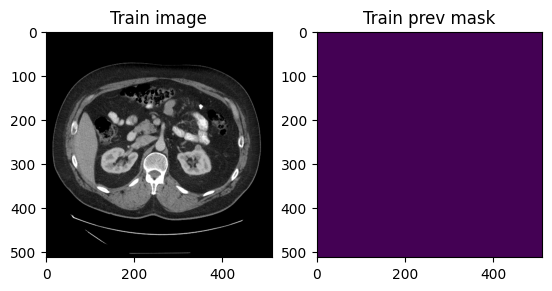

In [25]:
# inside model
image, prev_mask = trainer.net.prepare_input(net_input)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Train image')
ax[0].imshow(image[0, 0].cpu().numpy(), cmap='gray')
ax[1].set_title('Train prev mask')
ax[1].imshow(prev_mask[0, 0].cpu().numpy())


In [26]:
new_dist_maps = trainer.net.dist_maps
from isegm.ritm.model.ops import DistMaps as OldDistMaps
old_dist_maps = OldDistMaps(
    norm_radius=5,
    spatial_scale=1.0,
    cpu_mode=False,
    use_disks=True,
    dynamic_radius=False,
    overwrite_maps=False
)

In [27]:
model = trainer.net
model.dist_maps = new_dist_maps
# New Dist map settings:
# Dist map mode: disk
# T_destination: ~T_destination
# cpu_mode: False
# dump_patches: False
# dynamic_radius: None
# mode: disk
# norm_radius: 5
# overwrite_maps: False
# spatial_scale: 1.0
# training: True
# use_disks: False

print(model.dist_maps.__class__)
for param in dir(model.dist_maps):
    if not param.startswith('_') and not callable(model.dist_maps.__getattribute__(param)):
        print(f'{param}: {model.dist_maps.__getattribute__(param)}')

<class 'isegm.model.ops_v2.DistMaps'>
T_destination: ~T_destination
cpu_mode: False
dump_patches: False
dynamic_radius: None
mode: disk
norm_radius: 5
overwrite_maps: False
spatial_scale: 1.0
training: True
use_disks: False


In [28]:
model.dist_maps = old_dist_maps
# Old dist map settings:
# T_destination: ~T_destination
# cpu_mode: False
# dump_patches: False
# dynamic_radius: False
# norm_radius: 5
# overwrite_maps: False
# spatial_scale: 1.0
# training: True
# use_disks: True

print(model.dist_maps.__class__)
for param in dir(model.dist_maps):
    if not param.startswith('_') and not callable(model.dist_maps.__getattribute__(param)):
        print(f'{param}: {model.dist_maps.__getattribute__(param)}')

<class 'isegm.ritm.model.ops.DistMaps'>
T_destination: ~T_destination
cpu_mode: False
dump_patches: False
dynamic_radius: False
norm_radius: 5
overwrite_maps: False
spatial_scale: 1.0
training: True
use_disks: True


In [29]:
model = trainer.net
model.dist_maps = new_dist_maps
new_coord_features = model.get_coord_features(image, prev_mask, gpu_points)
print(new_coord_features.shape, new_coord_features.dtype)
model.dist_maps = old_dist_maps
old_coord_features = model.get_coord_features(image, prev_mask, gpu_points)
print(old_coord_features.shape, old_coord_features.dtype)

torch.Size([1, 3, 512, 512]) torch.float32
torch.Size([1, 3, 512, 512]) torch.float32


/gpfs/space/home/donatasv/.conda/envs/bcv_clickseg/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


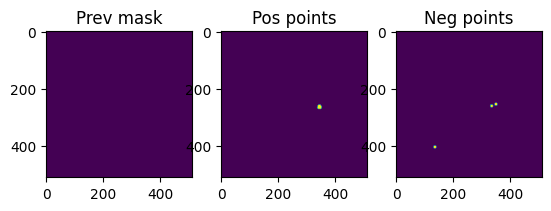

In [30]:
# New features
fig, ax = plt.subplots(1, 3)
ax[0].set_title('Prev mask')
ax[0].imshow(new_coord_features[0, 0].cpu().numpy())
ax[1].set_title('Pos points')
ax[1].imshow(new_coord_features[0, 1].cpu().numpy())
ax[2].set_title('Neg points')
ax[2].imshow(new_coord_features[0, 2].cpu().numpy())

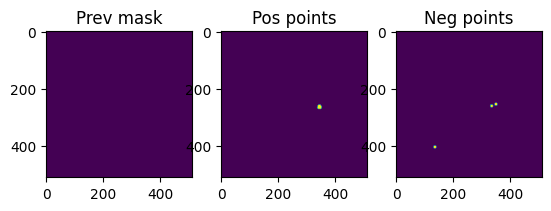

In [31]:
# Old features
fig, ax = plt.subplots(1, 3)
ax[0].set_title('Prev mask')
ax[0].imshow(old_coord_features[0, 0].cpu().numpy())
ax[1].set_title('Pos points')
ax[1].imshow(old_coord_features[0, 1].cpu().numpy())
ax[2].set_title('Neg points')
ax[2].imshow(old_coord_features[0, 2].cpu().numpy())

In [32]:
print(torch.sum(new_coord_features))
print(torch.sum(old_coord_features))
print(torch.sum(new_coord_features - old_coord_features))

tensor(440., device='cuda:0')
tensor(440., device='cuda:0')
tensor(0., device='cuda:0')


In [33]:
print(torch.sum(new_coord_features[0, 0] - old_coord_features[0, 0]))
print(torch.sum(new_coord_features[0, 1] - old_coord_features[0, 1]))
print(torch.sum(new_coord_features[0, 2] - old_coord_features[0, 2]))

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


float32
(array([0.], dtype=float32), array([262144]))


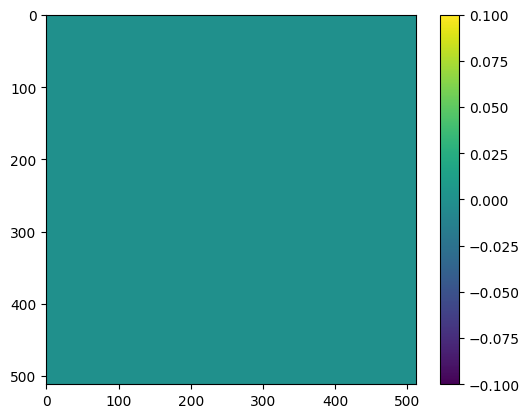

In [34]:
fig, ax = plt.subplots(1, 1)
import numpy as np
diff = np.abs((new_coord_features[0, 1] - old_coord_features[0, 1]).cpu().numpy())
print(diff.dtype)
print(np.unique(diff, return_counts=True))
a = ax.imshow(diff)
fig.colorbar(a)

In [35]:
gpu_points

tensor([[[265., 346.,   0.,   5.],
         [264., 343., 100.,   5.],
         [266., 348., 100.,   5.],
         [268., 343., 100.,   5.],
         [267., 342., 100.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [268., 347.,   2.,   5.],
         [262., 345.,   1.,   5.],
         [256., 350., 100.,   5.],
         [406., 136., 100.,   5.],
         [262., 335., 100.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.

0.0

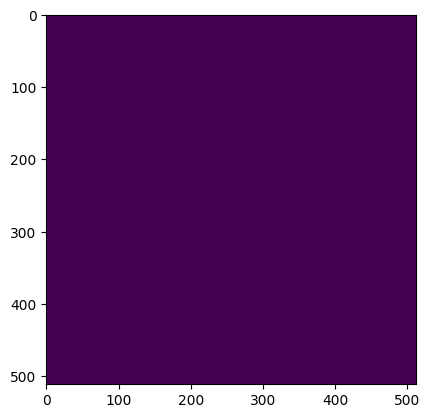

In [36]:
negative_diff = new_coord_features[0, 2] - old_coord_features[0, 2]
negative_diff = negative_diff.cpu().numpy()
fig, ax = plt.subplots(1, 1)
ax.imshow(negative_diff)
np.sum(negative_diff)

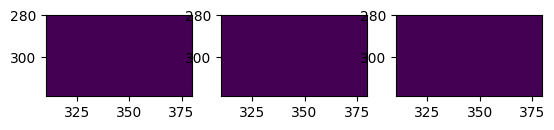

In [37]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(new_coord_features[0, 1].cpu().numpy())
ax[1].imshow(old_coord_features[0, 1].cpu().numpy())
ax[2].imshow(diff)
for a in ax:
    a.set_ylim(319, 280)
    a.set_xlim(310, 380)